In [32]:
import pandas as pd
import numpy as np
from copy import deepcopy

import json
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
plt.style.use(['science', 'no-latex'])

from matplotlib.lines import Line2D

import os
import sys
sys.path.append(os.path.abspath('.'))
from src.plots import set_size

labelmap = {
    "mlp_onehot": "MLP (One-hot)",
    "cnn": "1D-CNN + MLP",
    "mean_transformer": "Transformer (Mean Pooling)",
}

In [65]:
LOGS_DIR = "logs_adversarial_poisoning_pollution_WEIRD"
score_files = [os.path.join(LOGS_DIR, f) for f in os.listdir(LOGS_DIR) if f.startswith("poisoned_scores_")]

cnn_scores = {}
mlp_scores = {}
transformer_scores = {}

for score_file in score_files:
    poison_ratio = float(score_file.split("_")[-1].replace(".json", ""))
    with open(score_file) as f:
        scores = json.load(f)
        if "cnn" in score_file:
            cnn_scores[poison_ratio] = scores
        elif "mlp" in score_file:
            mlp_scores[poison_ratio] = scores
        elif "transformer" in score_file:
            transformer_scores[poison_ratio] = scores

In [66]:
def plot_scatter_lines(scores, metric="f1", model_name="", xlim=[0.0007, 1]):
    scores = deepcopy(scores)
    fig, ax = plt.subplots(1, 1, figsize=set_size())
    # sort keys in scores
    scores = {k: scores[k] for k in sorted(scores.keys())}

    # remove 0.0 as baseline and remove from scoress
    baseline = scores[0.0]
    scores.pop(0.0, None)

    x = scores.keys()
    y = [v[metric] for v in scores.values()]

    ax.scatter(x, y, color="black")
    ax.plot(x, y, "--", color="black", alpha=0.5)

    # plot baseline as horizontal line red line
    ax.plot([0, 1], [baseline[metric], baseline[metric]], "--", color="red", alpha=0.5)

    ax.set_xlabel("Poison Ratio")
    ax.set_ylabel(metric.upper())
    ax.set_title(model_name)
    ax.set_xscale("log")
    if xlim is not None:
        ax.set_xlim(xlim)
    return fig, ax

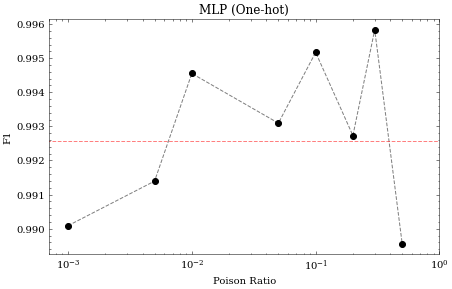

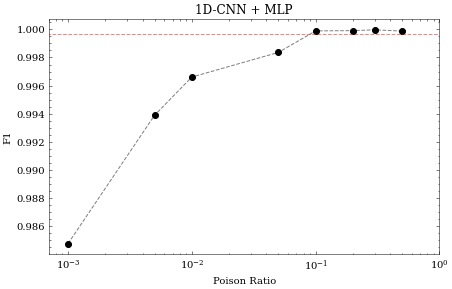

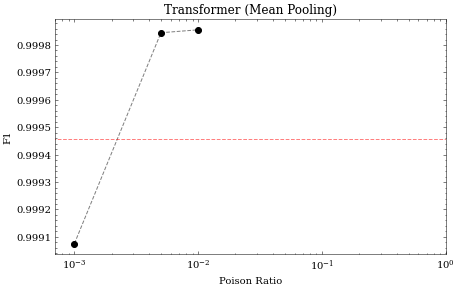

In [67]:
metric = "f1"
for name, score in zip(labelmap.keys(), [mlp_scores, cnn_scores, transformer_scores]):
    plot_scatter_lines(score, model_name=labelmap[name], metric=metric)

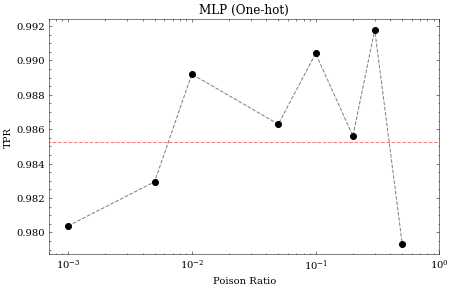

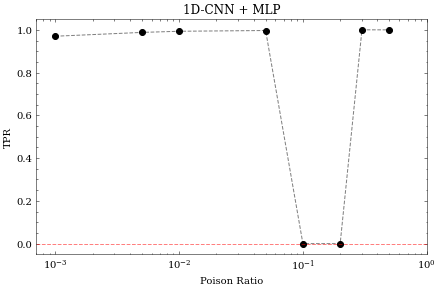

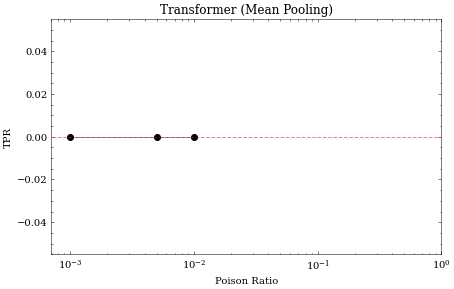

In [68]:
metric = "tpr"
for name, score in zip(labelmap.keys(), [mlp_scores, cnn_scores, transformer_scores]):
    plot_scatter_lines(score, model_name=labelmap[name], metric=metric)

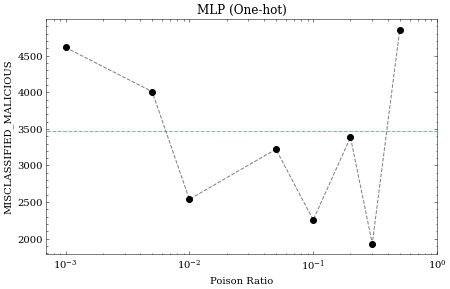

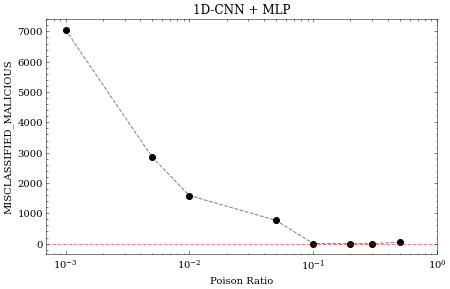

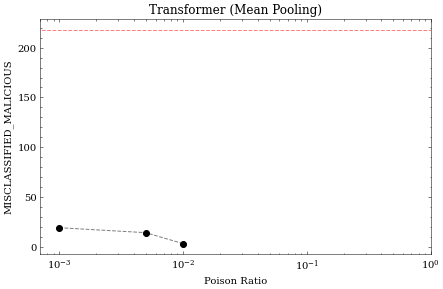

In [69]:
metric = "misclassified_malicious"
for name, score in zip(labelmap.keys(), [mlp_scores, cnn_scores, transformer_scores]):
    plot_scatter_lines(score, model_name=labelmap[name], metric=metric)

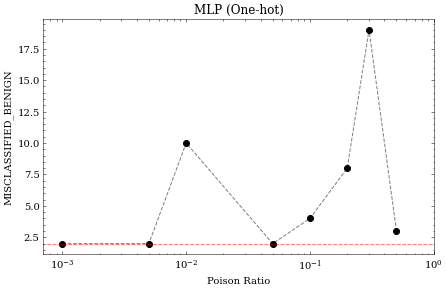

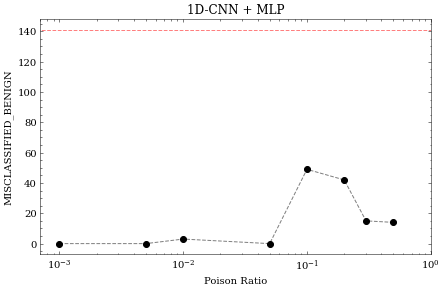

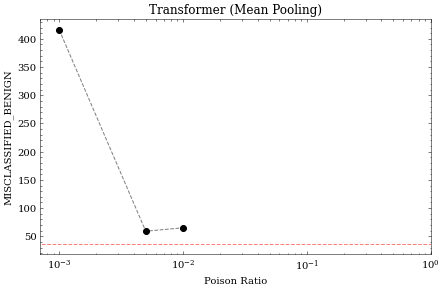

In [70]:
metric = "misclassified_benign"
for name, score in zip(labelmap.keys(), [mlp_scores, cnn_scores, transformer_scores]):
    plot_scatter_lines(score, model_name=labelmap[name], metric=metric)

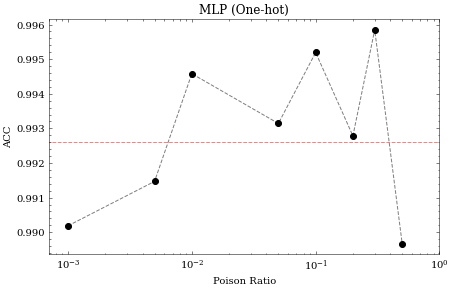

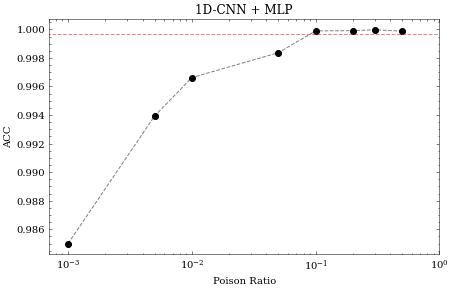

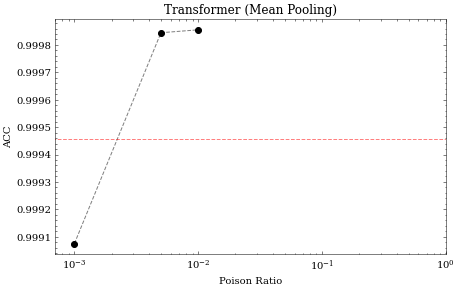

In [71]:
metric = "acc"
for name, score in zip(labelmap.keys(), [mlp_scores, cnn_scores, transformer_scores]):
    plot_scatter_lines(score, model_name=labelmap[name], metric=metric)